In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.distributions import Normal

In [3]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


In [4]:
# Define the neural network
class CustomizableNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, num_layers, use_bias):
        super(CustomizableNN, self).__init__()

        # Validate input
        assert num_layers == len(hidden_sizes), "Number of hidden layers should match the length of hidden_sizes."

        # Input layer
        layers = [nn.Linear(input_size, hidden_sizes[0], bias=use_bias[0]),nn.Sigmoid()]

        # Hidden layers
        for i in range(1, num_layers):
            layers += [nn.Linear(hidden_sizes[i - 1], hidden_sizes[i], bias=use_bias[i]), nn.Sigmoid()]

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size, bias=use_bias[-1]))

        # Combine layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example usage for Iris dataset:
input_size = 4  # Four features in the Iris dataset
output_size = 3  # Three classes in the Iris dataset
hidden_sizes = [20, 20, 20, 20]
num_layers = len(hidden_sizes)
use_bias = [0,0,0,0]
#use_bias = reshape([0 for i in range(67)])

# Create a customizable neural network for the Iris dataset
model = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias)

In [5]:
def reshape(original_list, rows=num_layers, columns=hidden_sizes[0], add_size=3):

    reshaped_list = [original_list[i:i + columns] for i in range(0, rows * columns, columns)]
    add = original_list[-add_size:]
    reshaped_list.append(add)
    return reshaped_list



In [6]:
# Define Mean Squared Error (MSE) as the loss function
def loss_back(model, num_epochs,criterion = nn.CrossEntropyLoss(), lr=0.001):
    # Define loss function and optimizer
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         # Print progress
#         if (epoch + 1) % 10 == 0:
#             print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


In [7]:
loss_back(model, num_epochs=200, lr=0.001)

In [8]:
# Evaluation on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

print(f'Accuracy on the test set: {accuracy * 100:.2f}%')


Accuracy on the test set: 50.00%


In [9]:
# Print the result weights and biases of each layer
for name, param in model.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    if 'weight' in name:
        print(f'Weights: {param.data.size()}')
    elif 'bias' in name:
        print(f'Biases: {param.data}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([20, 4])
Weights: torch.Size([20, 4])
Layer: model.2.weight, Size: torch.Size([20, 20])
Weights: torch.Size([20, 20])
Layer: model.4.weight, Size: torch.Size([20, 20])
Weights: torch.Size([20, 20])
Layer: model.6.weight, Size: torch.Size([20, 20])
Weights: torch.Size([20, 20])
Layer: model.8.weight, Size: torch.Size([3, 20])
Weights: torch.Size([3, 20])


In [10]:
# Print the derivatives of the loss with respect to each parameter
for name, param in model.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    #print(f'Gradient: {param.grad}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([20, 4])
Layer: model.2.weight, Size: torch.Size([20, 20])
Layer: model.4.weight, Size: torch.Size([20, 20])
Layer: model.6.weight, Size: torch.Size([20, 20])
Layer: model.8.weight, Size: torch.Size([3, 20])


In [11]:
def fisher_diagonal(model,i):
    all_gradients_weight = [param.grad for name, param in model.named_parameters() if "weight" in name ]
    all_gradients_bias = [param.grad for name, param in model.named_parameters() if "bias" in name ]
    grad_vector_weight_hidden = torch.cat([g.contiguous().view(-1) for g in all_gradients_weight[:-1]])
    grad_vector_weight_output = torch.cat([g.contiguous().view(-1) for g in all_gradients_weight[-1][i]])
    grad_vector_weight = torch.cat([grad_vector_weight_hidden, grad_vector_weight_output],0)
    if len(all_gradients_bias) > 0:
        grad_vector_bias_hidden = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias[:-1]])
        grad_vector_bias_output = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias[-1]])
        grad_vector_bias = torch.cat([grad_vector_bias_hidden, grad_vector_bias_output],0)
        grad_vector = torch.cat([grad_vector_weight,grad_vector_bias],0)
    else:
        grad_vector = grad_vector_weight
    grad_vector = grad_vector.view(-1, 1)
#         for param, gradient in zip(model.parameters(), all_gradients):
#             print(f"Gradient of loss w.r.t. {param[i]}:")
#             print(gradient)
#             print()
#         print('='*20)
#         print(grad_vector)
    G=torch.transpose(grad_vector,0,1)
    F=torch.matmul(grad_vector,G)
    return F,G,grad_vector

In [12]:
def prob(outputs,labels,size_y):
    # re-probability outputs
    mini, _ = torch.min(outputs.data, 1)

    re_outputs = outputs-mini.view(-1, 1)
    re_outputs_p = re_outputs/torch.sum(re_outputs,1).view(-1, 1)
    
    # re-probability labels
    _, predicted = torch.max(outputs.data, 1)
    num_elements = labels.numel()
    identity_matrix = torch.eye(size_y)
    re_labels_p = identity_matrix[labels] # set probability of labels
    return re_outputs_p, re_labels_p

In [13]:
def confi_pred_interval(inputs, labels, model,size_y, a=0.025):
    """
    Function:
    - Calculate the confidence interval and predictive interval of results
    Input:
    - inout: The input of data
    - label: The label of handwriting input
    - model: The trained neural network
    - a: significant level
    Returns:
    - c: the size of confidence interval
    - c_p: the list of confidence interval for each kinds label {0,1,...,9}
    - mu: the estimate output
    - y_p: the list of predictive interval for each kinds label {0,1,...,9}
    """
    Z= norm.ppf(1 - a / 2)
    c = torch.tensor([])
    c_p = torch.tensor([])
    outputs = model(inputs)
    re_outputs_p, re_labels_p = prob(outputs,labels,size_y)
    # loss for CI
    mu = torch.mean(re_outputs_p,dim=0) # mean of estimator of y
    loss = torch.sum((re_outputs_p-re_labels_p)**2,1)/2
    
    # loss for PI
    y_p = torch.mean(re_labels_p,dim=0)
    loss_p = torch.sum((re_outputs_p-y_p)**2,1)/2
    
    for i in range(size_y):
        print(f"number:{i}")
        print('='*20)
        F, G, grad_vector = fisher_diagonal(model,i)
        H=torch.pinverse(F) #use the pseudo-inverse 
        print(H.size())
        w=torch.mm(G,H)
        w=torch.mm(w,grad_vector)
        
        # CI
        sigma_epsilon_squared = loss[i]/len(labels)
        sigma=torch.sqrt(w*sigma_epsilon_squared)
        ci=sigma*Z
        CI= torch.cat([mu[i] - ci, mu[i] + ci],1)
        c = torch.cat([c, CI.unsqueeze(0)], 1) #combing the CI as squence
        
        # PI
        sigma_epsilon_squared_p = loss_p[i]/len(labels)
        sigma_p=torch.sqrt(sigma_epsilon_squared_p)
        ci_p=sigma_p*Z
        ci_p_list=[mu[i] - ci_p, mu[i] + ci_p]
        ci_p_list=[tensor.view(1, 1) for tensor in ci_p_list]
        CI_p= torch.cat(ci_p_list,1)
        c_p = torch.cat([c_p, CI_p.unsqueeze(0)], 1) #combing the CI as squence
#         print('='*20)
#         print(f"fisher information matrix:{F}")
#         print(f"Inverse hessian:{H}")
#         print(f"mean of estimator probability:{mu[i]}")
        print(f"interva size:{ci}")
        print(f"p interva size:{ci_p}")
#         print(c)
    return c, c_p, mu, y_p

In [14]:

    c, c_p, mu, y_p= confi_pred_interval(X_train_tensor, y_train_tensor, model,size_y=3, a=0.025)

number:0
torch.Size([1300, 1300])
interva size:tensor([[0.1360]], grad_fn=<MulBackward0>)
p interva size:0.06820525974035263
number:1
torch.Size([1300, 1300])
interva size:tensor([[0.0213]], grad_fn=<MulBackward0>)
p interva size:0.11796373128890991
number:2
torch.Size([1300, 1300])
interva size:tensor([[0.1060]], grad_fn=<MulBackward0>)
p interva size:0.06820418685674667


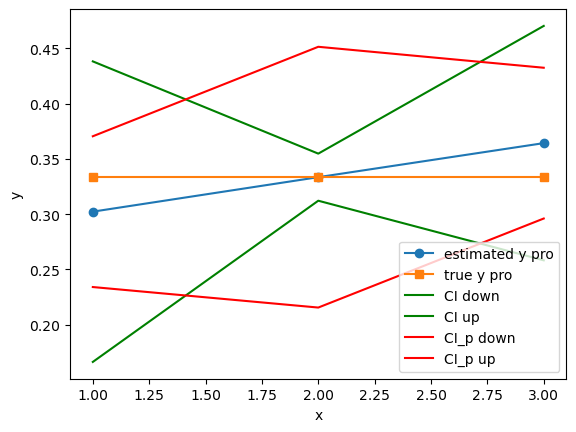

In [15]:
x_np = range(1, 4)
mu_np = mu.detach().numpy()
c_np = c.detach().numpy()
c_p_np = c_p.detach().numpy()
y_np = y_p.detach().numpy()
# Plotting with conditional formatting
plt.plot(x_np, mu_np, 'o-', label='estimated y pro')
plt.plot(x_np, y_np, 's-', label='true y pro')
plt.plot(x_np, c_np[0,:,0], '-', label='CI down', color='green')
plt.plot(x_np, c_np[0,:,1], '-', label='CI up',color='green')
plt.plot(x_np, c_p_np[0,:,0], '-', label='CI_p down', color='red')
plt.plot(x_np, c_p_np[0,:,1], '-', label='CI_p up', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()


In [16]:
model_adj = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias = [True,True,True,True,True,True,True] )

In [17]:
loss_back(model_adj, num_epochs=100, criterion = nn.CrossEntropyLoss(), lr=0.001)

In [18]:
# Print the result weights and biases of each layer
for name, param in model_adj.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    if 'weight' in name:
        print(f'Weights: {param.data.size()}')
    elif 'bias' in name:
        print(f'Biases: {param.data.size()}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([20, 4])
Weights: torch.Size([20, 4])
Layer: model.0.bias, Size: torch.Size([20])
Biases: torch.Size([20])
Layer: model.2.weight, Size: torch.Size([20, 20])
Weights: torch.Size([20, 20])
Layer: model.2.bias, Size: torch.Size([20])
Biases: torch.Size([20])
Layer: model.4.weight, Size: torch.Size([20, 20])
Weights: torch.Size([20, 20])
Layer: model.4.bias, Size: torch.Size([20])
Biases: torch.Size([20])
Layer: model.6.weight, Size: torch.Size([20, 20])
Weights: torch.Size([20, 20])
Layer: model.6.bias, Size: torch.Size([20])
Biases: torch.Size([20])
Layer: model.8.weight, Size: torch.Size([3, 20])
Weights: torch.Size([3, 20])
Layer: model.8.bias, Size: torch.Size([3])
Biases: torch.Size([3])


In [19]:
for name, param in model_adj.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    print(f'Gradient: {param.grad.size()}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([20, 4])
Gradient: torch.Size([20, 4])
Layer: model.0.bias, Size: torch.Size([20])
Gradient: torch.Size([20])
Layer: model.2.weight, Size: torch.Size([20, 20])
Gradient: torch.Size([20, 20])
Layer: model.2.bias, Size: torch.Size([20])
Gradient: torch.Size([20])
Layer: model.4.weight, Size: torch.Size([20, 20])
Gradient: torch.Size([20, 20])
Layer: model.4.bias, Size: torch.Size([20])
Gradient: torch.Size([20])
Layer: model.6.weight, Size: torch.Size([20, 20])
Gradient: torch.Size([20, 20])
Layer: model.6.bias, Size: torch.Size([20])
Gradient: torch.Size([20])
Layer: model.8.weight, Size: torch.Size([3, 20])
Gradient: torch.Size([3, 20])
Layer: model.8.bias, Size: torch.Size([3])
Gradient: torch.Size([3])


In [20]:
def numerical_derivative(model,NN, bias, j,epsilon):
    """
    Function:
    -Numerically approximate the derivative of a function f at point x using finite differences.
    Input:
    - model:the Neural network model
    - bias: The bias list for 
    - i: The index of target output
    - j: The index of target bias to derivative
    Returns:
    - derivative for parameter y[i]
    """
    derivative = torch.tensor([])
    bias_plus_epsilon = bias
    bias_minus_epsilon = bias
    bias_plus_epsilon[j] = bias[j] + epsilon
    bias_minus_epsilon[j] = bias[j] - epsilon
    bias_plus = reshape(bias_plus_epsilon)
    bias_minus = reshape(bias_minus_epsilon)
    model_up = NN(input_size, output_size, hidden_sizes, num_layers, bias_plus)
    model_down = NN(input_size, output_size, hidden_sizes, num_layers, bias_minus)
    print(f"bias num:{j} complete")
    loss_back(model_up, num_epochs=100, lr=0.001)
    loss_back(model_down, num_epochs=100, lr=0.001)
    
    for i in range(3):
        all_gradients_bias_up = [param.grad for name, param in model_up.named_parameters() if "weight" in name ]
        grad_vector_bias_hidden_up = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_up[:-1]])
        grad_vector_bias_output_up = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_up[-1][i]])
        grad_vector_bias_up = torch.cat([grad_vector_bias_hidden_up, grad_vector_bias_output_up],0)
        grad_vector_bias_up = grad_vector_bias_up.view(-1, 1)
        
        all_gradients_bias_down = [param.grad for name, param in model_down.named_parameters() if "weight" in name ]
        grad_vector_bias_hidden_down = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_down[:-1]])
        grad_vector_bias_output_down = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_down[-1][i]])
        grad_vector_bias_down = torch.cat([grad_vector_bias_hidden_down, grad_vector_bias_output_down],0)
        grad_vector_bias_down = grad_vector_bias_down.view(-1, 1)
        
        each_derivative = (grad_vector_bias_up-grad_vector_bias_down)/ 2 * epsilon
        derivative = torch.cat([derivative, each_derivative.unsqueeze(0)], 0)
    
    return derivative

In [21]:
def derivative_whole(use_bias, epsilon=1e-6):
    dS_da_whole = torch.tensor([])
    for j in range(len(use_bias)):
        detrivate = numerical_derivative(model,CustomizableNN, deepcopy(use_bias), j,epsilon)
        dS_da_whole = torch.cat([dS_da_whole, detrivate], -1)
    return dS_da_whole

In [22]:
dS_da_whole=derivative_whole(use_bias=[0 for _ in range(sum(hidden_sizes)+3)])

bias num:0 complete
bias num:1 complete
bias num:2 complete
bias num:3 complete
bias num:4 complete
bias num:5 complete
bias num:6 complete
bias num:7 complete
bias num:8 complete
bias num:9 complete
bias num:10 complete
bias num:11 complete
bias num:12 complete
bias num:13 complete
bias num:14 complete
bias num:15 complete
bias num:16 complete
bias num:17 complete
bias num:18 complete
bias num:19 complete
bias num:20 complete
bias num:21 complete
bias num:22 complete
bias num:23 complete
bias num:24 complete
bias num:25 complete
bias num:26 complete
bias num:27 complete
bias num:28 complete
bias num:29 complete
bias num:30 complete
bias num:31 complete
bias num:32 complete
bias num:33 complete
bias num:34 complete
bias num:35 complete
bias num:36 complete
bias num:37 complete
bias num:38 complete
bias num:39 complete
bias num:40 complete
bias num:41 complete
bias num:42 complete
bias num:43 complete
bias num:44 complete
bias num:45 complete
bias num:46 complete
bias num:47 complete
bi

# estimate Va

In [23]:
model_va = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias = [True,True,True,True,True,True,True] )
# Store estimated bias terms for each batch
estimated_bias_per_batch = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_va.parameters(), lr=0.001)  
# Training loop
for i in range(10):
    # Split the dataset into training and testing sets
    X_tr, X_tt, y_tr, y_tt = train_test_split(X_test, y_test, test_size=0.3, random_state=i, stratify=y_test)
    # Standardize the features
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_tt = scaler.transform(X_tt)

    # Convert NumPy arrays to PyTorch tensors
    X_tr_tensor = torch.FloatTensor(X_tr)
    y_tr_tensor = torch.LongTensor(y_tr)
    # Training the model
    # Zero the gradients
    optimizer.zero_grad()
    for epoch in range(1000):
            outputs = model_va(X_tr_tensor)
            loss = criterion(outputs, y_tr_tensor)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    estimated_bias_per_layer = [param.detach().numpy() for name, param in model_va.named_parameters() if 'bias' in name]
    estimated_bias_per_layer =np.concatenate(estimated_bias_per_layer).tolist()
    estimated_bias_per_batch.append(estimated_bias_per_layer)



In [24]:
def variance(data):
    # Define the Bayesian linear regression model
    class BayesianLinearRegression(nn.Module):
        def __init__(self):
            super(BayesianLinearRegression, self).__init__()
            self.mean_weight = nn.Parameter(torch.randn(1))
            self.log_variance_weight = nn.Parameter(torch.randn(1))

        def forward(self, x):
            mean = x * self.mean_weight
            variance = torch.exp(self.log_variance_weight)
            return Normal(mean, variance.sqrt())

    # Instantiate the model and set up optimization
    model_B = BayesianLinearRegression()
    optimizer = optim.Adam(model_B.parameters(), lr=0.01)

    # Training loop for Bayesian inference
    num_epochs = 1000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        likelihood = model_B(data)
        loss = -likelihood.log_prob(data).sum()  # Negative log likelihood as loss
        loss.backward()
        optimizer.step()

    # Get the estimated variance from the model
    estimated_variance = torch.exp(model_B.log_variance_weight).item()
    return estimated_variance

In [25]:
V = []
for i in range(len(estimated_bias_per_batch[1])):
    data_list = [per_batch[i] for per_batch in estimated_bias_per_batch]
    data = torch.tensor(data_list, dtype=torch.float32)
    var = variance(data)
    V.append(var)
V = torch.tensor(V)

In [26]:
def Adjust(model_adj,hidden_sizes,dS_da_whole,train_loader,V):
    Adj = torch.tensor([])
    for i in range(3):
        F, G, grad_vector = fisher_diagonal(model_adj,i)
        F_in= torch.pinverse(F)
        r = len(F)
        l = sum(hidden_sizes)+3
        n = len(train_loader)
        grad_v=grad_vector[0:r-l]
        Va = torch.diag(V, diagonal=0)
        Vo = (F_in[0:r-l,0:r-l])
        dS_da = dS_da_whole[i,:,:]
        D = torch.mm(Vo,dS_da)
        D_t = torch.transpose(D,0,1)
        if D.dtype != Va.dtype:
            Va = Va.to(D.dtype)
        A = torch.mm(D,Va)
        A = torch.mm(A,D_t)
        Adj = torch.cat([Adj, A.unsqueeze(0)], 0)
    return Adj,grad_v

In [27]:
Adj,grad_v= Adjust(model_adj,hidden_sizes,dS_da_whole,X_train_tensor,V)

In [28]:
def adj_confi_pred_interval(inputs, labels, model, Adj, grad_vector,size_y, a=0.025):
    Z= norm.ppf(1 - a / 2)
    c = torch.tensor([])
    c_p = torch.tensor([])
    outputs = model(inputs)
    re_outputs_p, re_labels_p = prob(outputs,labels,size_y)
    
    # loss for CI
    mu = torch.mean(re_outputs_p,dim=0) # mean of estimator of y
    loss = torch.sum((re_outputs_p-re_labels_p)**2,1)/2
    
    # loss for PI
    y_p = torch.mean(re_labels_p,dim=0)
    loss_p = torch.sum((re_outputs_p-y_p)**2,1)/2
    
    for i in range(size_y):
        print(f"number:{i}")
        print('='*20)
        F, G, grad_vector = fisher_diagonal(model,i)
        H=torch.pinverse(F) #use the pseudo-inverse 
        H = H + Adj[i]
        print(Adj[i])
        G = grad_vector.view(1, -1)
        w = torch.mm(G,H)
        w = torch.mm(w,grad_vector)
        print(w)

        # CI
        sigma_epsilon_squared = loss[i]/len(labels)
        sigma=torch.sqrt(w*sigma_epsilon_squared)
        ci=sigma*Z
        CI= torch.cat([mu[i] - ci, mu[i] + ci],1)
        c = torch.cat([c, CI.unsqueeze(0)], 1) #combing the CI as squence
        print(ci)
        
        # PI
        sigma_epsilon_squared_p = loss_p[i]/len(labels)
        sigma_p=torch.sqrt(sigma_epsilon_squared_p)
        ci_p=sigma_p*Z
        ci_p_list=[mu[i] - ci_p, mu[i] + ci_p]
        ci_p_list=[tensor.view(1, 1) for tensor in ci_p_list]
        CI_p= torch.cat(ci_p_list,1)
        c_p = torch.cat([c_p, CI_p.unsqueeze(0)], 1) #combing the CI as squence
#         print('='*20)
#         print(f"fisher information matrix:{F}")
#         print(f"Inverse hessian:{H}")
#         print(f"mean of estimator probability:{mu[i]}")
#         print(f"interva size:{ci}")
#         print(f"p interva size:{ci_p}")
#         print(c)
    return c, c_p, mu, y_p

In [29]:
c, c_p, mu, y_p= confi_pred_interval(X_train_tensor, y_train_tensor, model,size_y=3, a=0.025)
adj_c, adj_c_p, mu, y_p= adj_confi_pred_interval(X_train_tensor, y_train_tensor, model, Adj,grad_v,size_y=3, a=0.025)
  

number:0
torch.Size([1300, 1300])
interva size:tensor([[0.1360]], grad_fn=<MulBackward0>)
p interva size:0.06820525974035263
number:1
torch.Size([1300, 1300])
interva size:tensor([[0.0213]], grad_fn=<MulBackward0>)
p interva size:0.11796373128890991
number:2
torch.Size([1300, 1300])
interva size:tensor([[0.1060]], grad_fn=<MulBackward0>)
p interva size:0.06820418685674667
number:0
tensor([[ 0.0470,  0.0037, -0.0279,  ..., -0.0033,  0.0052, -0.0065],
        [ 0.0037,  0.1299, -0.1577,  ..., -0.0320,  0.0038, -0.0030],
        [-0.0279, -0.1577,  0.4076,  ...,  0.0476, -0.0526,  0.0195],
        ...,
        [-0.0033, -0.0320,  0.0476,  ...,  0.3405,  0.0160, -0.0315],
        [ 0.0052,  0.0038, -0.0526,  ...,  0.0160,  0.1928,  0.0726],
        [-0.0065, -0.0030,  0.0195,  ..., -0.0315,  0.0726,  0.2122]])
tensor([[1.3224]])
tensor([[0.1364]], grad_fn=<MulBackward0>)
number:1
tensor([[ 0.2408,  0.0333, -0.0629,  ...,  0.1140, -0.0651, -0.0422],
        [ 0.0333,  0.0228, -0.0248,  ...,

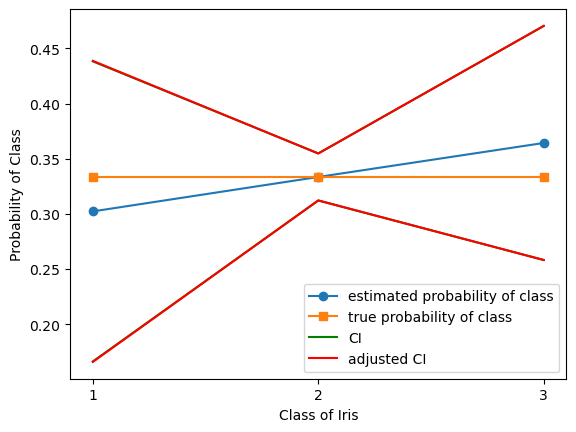

<Figure size 640x480 with 0 Axes>

In [30]:
x_np = range(1, 4)
mu_np = mu.detach().numpy()
c_np = c.detach().numpy()
c_p_np = c_p.detach().numpy()
adj_c_np = adj_c.detach().numpy()
adj_c_p_np = adj_c_p.detach().numpy()
y_np = y_p.detach().numpy()
# Plotting with conditional formatting
plt.plot(x_np, mu_np, 'o-', label='estimated probability of class')
plt.plot(x_np, y_np, 's-', label='true probability of class')
plt.plot(x_np, c_np[0,:,0], '-', label='CI', color='green')
plt.plot(x_np, c_np[0,:,1], '-',color='green')
plt.plot(x_np, adj_c_np[0,:,0], '-', label='adjusted CI', color='red')
plt.plot(x_np, adj_c_np[0,:,1], '-',color='red')
plt.xticks([1, 2, 3])
plt.xlabel('Class of Iris')
plt.ylabel('Probability of Class')
plt.legend()
plt.show()
# plt.savefig('iris NN 20x4.jpg', format='jpg')


In [167]:
# import torch

# # Save the results to a file
# torch.save({'adj_c': adj_c, 'adj_c_p': adj_c_p, 'mu': mu, 'y_p': y_p,
#             'c': c, 'c_p': c_p, 'mu': mu, 'y_p': y_p}, 'confidence_intervals_iris_more.pth')

# # Load the data back into your program
# loaded_data = torch.load('confidence_intervals_iris_more.pth')

# # Access the saved variables
# loaded_adj_c = loaded_data['adj_c']
# loaded_adj_c_p = loaded_data['adj_c_p']
# loaded_mu = loaded_data['mu']
# loaded_y_p = loaded_data['y_p']
# loaded_c = loaded_data['c']
# loaded_c_p = loaded_data['c_p']
# loaded_mu = loaded_data['mu']
# loaded_y_p = loaded_data['y_p']
